## Домашнее задание 2
### Выполнил: 
    -> Башаров Илья Валерьевич
    -> ilya.basharov.98@mail.ru

In [2]:
from stats import (
    player_per_team,
    questions_per_tournament,
    percentage_correct_per_tournament,
    percentage_correct_per_team,
)

from dataset import (
    read_dataset,
    preprocess,
    train_test_split,
)

from features import (
    create_train_matrix_baseline,
    create_test_prediction,
)

from datetime import (
    datetime,
    timedelta,
)

import numpy   as np
import pickle  as pk
import pandas  as pd
import scipy   as sp

import matplotlib.pyplot as plt
%matplotlib inline

##### 1.1 Прочитаем данные, выбрав турниры, в которых есть данные о составах команд и повопросных результатах.

In [ ]:
%%bash

wget -q https://www.dropbox.com/s/s4qj0fpsn378m2i/chgk.zip -O chgk.zip

In [3]:
date_start_train = datetime.strptime('2019-01-01', '%Y-%m-%d')
date_start_val = datetime.strptime('2020-01-01', '%Y-%m-%d')

all_data, players = preprocess(
    read_dataset('chgk.zip'),
    date_start_train,
)

##### 1.2 Проанализируем данные.

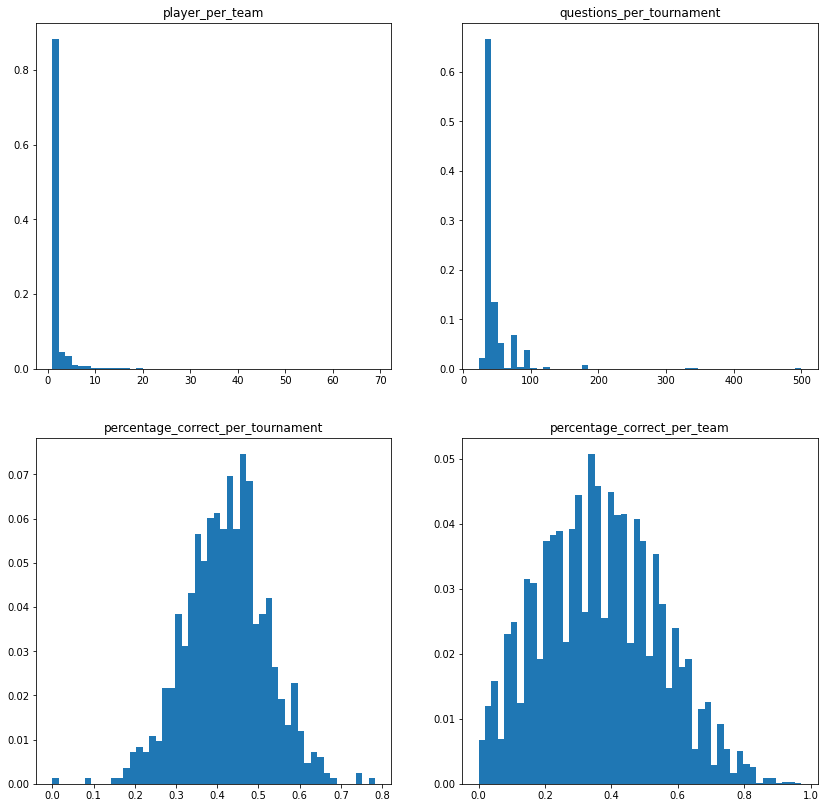

In [4]:
fig, axes2d = plt.subplots(2, 2, figsize=(14, 14))
axes = axes2d.flatten()

for i, aggregation in enumerate((
    player_per_team,
    questions_per_tournament,
    percentage_correct_per_tournament,
    percentage_correct_per_team)):
    
    dist = aggregation(all_data)
    w    = [1/len(dist)]*len(dist)
    
    axes[i].hist(dist.values(), weights=w, bins=50);
    axes[i].set_title(aggregation.__name__);

##### 1.3 Поделим данные на train, test

In [5]:
train, test = train_test_split(all_data, date_start_train, date_start_val)

##### 2.1 Постройте baseline-модель на основе линейной или логистической регрессии, которая будет обучать рейтинг-лист игроков.
Алгоритм создания матрицы признаков для линейной регрессии:

```python
feature_matrix = []
for tournament in tournaments:
    for question in questions:
        for member in team:
            feature = [one_hot(member), one_hot(question)]
            feature_matrix.append(feature)
```

In [6]:
X, y, ind2player = create_train_matrix_baseline(train, n_team=3)

In [7]:
from sklearn.linear_model import (
    LogisticRegression,
)

lr = LogisticRegression(tol=1e-2, solver='saga', C=1, n_jobs=-1, max_iter=1e3)
lr.fit(X, y);

In [8]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
)

pred = lr.predict(X)
for metric_function in (accuracy_score, precision_score, recall_score):
    print(metric_function.__name__, 'at trainset: %.3f' % metric_function(y, pred))

accuracy_score at trainset: 0.766
precision_score at trainset: 0.764
recall_score at trainset: 0.767


##### 3.1 Предложите способ предсказать результаты нового турнира с известными составами, но неизвестными вопросами, в виде ранжирования команд

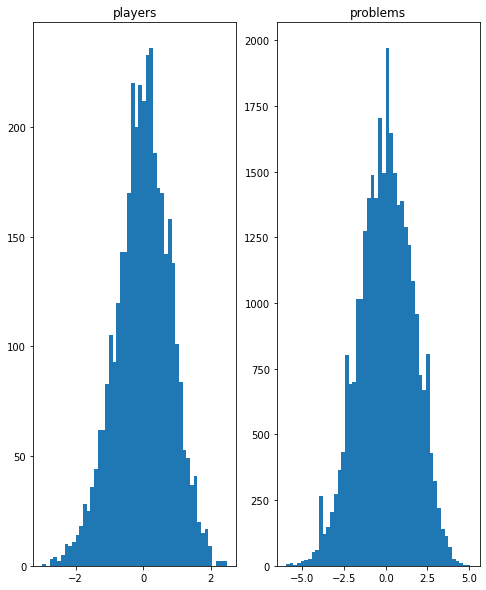

In [9]:
players_ranking = lr.coef_[0, :len(ind2player)]
problem_ranking = lr.coef_[0, len(ind2player):]

fig, axes1d = plt.subplots(1, 2, figsize=(8, 10))

for i, (ranking, ranking_name) in enumerate(zip(
    (players_ranking, problem_ranking),
    ('players', 'problems'))):
    axes1d[i].hist(ranking, bins=50);
    axes1d[i].set_title(ranking_name);

Видно, что 'сила' вопросов имеет экспоненциальное распроделение c центром в 0. В качестве вопроса для предсказания возьмем вопрос с весом w = 0. Поскольку $y = \sigma(\sum_{i}w_{i}x_{i})) = \sigma(\underbrace{\sum_{i}w_{i}x_{i}}_{players} + \underbrace{\sum_{j}w_{j}x_{j}}_{questions = 0})) = \sigma(\sum_{i}w_{i}x_{i})$

В качестве рейтинга будем использовать $\mathbb{P}(team = 1) = 1 - \prod_{player \in team}\mathbb{P}(player = 0)$, используя предположение о независимом голосовании (не учитывая, по сути, влияние 'силы' игрока, так как в жизни часто доверяют более 'сильным')

In [10]:
rating_pred, rating_gt = create_test_prediction(
    dataset=test,
    idx_to_player=ind2player,
    model=lr,
)

##### 3.2 В качестве метрики качества на тестовом наборе давайте считать ранговые корреляции Спирмена и Кендалла (их можно взять в пакете scipy) между реальным ранжированием в результатах турнира и предсказанным моделью, усреднённые по тестовому множеству турниров

In [11]:
spearman = [
    sp.stats.spearmanr(rating_gt[i], rating_pred[i]).correlation
    for i in range(len(rating_pred))
]

kendall = [
    sp.stats.kendalltau(rating_gt[i], rating_pred[i]).correlation
    for i in range(len(rating_pred))
]

spearman corellation is 0.642
kendall corellation is 0.496


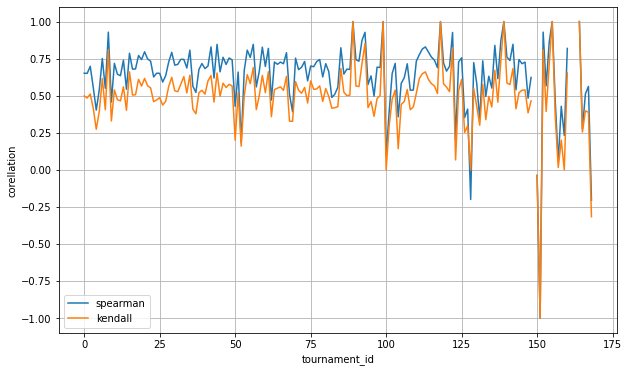

In [12]:
x_axis = range(len(spearman))
fig = plt.figure(figsize=(10, 6))

for data, label in zip((spearman, kendall), ('spearman', 'kendall')):
    plt.plot(x_axis, data, label=label)
    print('%s corellation is %.3f' % (label, np.nanmean(data)))

plt.xlabel('tournament_id')
plt.ylabel('corellation')
plt.grid(True)
plt.legend();

### Expectation–Maximization 
##### 4.1 Предложите способ учитывать то, что на вопрос отвечают сразу несколько игроков